In [1]:
import sys
sys.path.append('Image inpainting')

In [2]:
from augment_data import *
import keras
import tensorflow as tf
import os
from pconv_model import pconv_model
from pconv_layer import PConv2D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Input, Lambda, BatchNormalization, Activation, UpSampling2D, Concatenate, ReLU, LeakyReLU, Conv2D


In [3]:
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [4]:
segmentation_model_path="vggunet_brain_mri_seg.hdf5"
seg_model=keras.models.load_model(segmentation_model_path,compile=False)

## 1) Inpainting Augmentation

In [5]:
IMAGE_SIZE=256
def build_pconv_unet(train_bn=True):
        # INPUTS
        inputs_img = Input((IMAGE_SIZE, IMAGE_SIZE, 3), name='inputs_img')
        inputs_mask = Input((IMAGE_SIZE, IMAGE_SIZE, 3), name='inputs_mask')

        # ENCODER
        def encoder_layer(img_in, mask_in, filters, kernel_size, bn=True):
            conv, mask = PConv2D(filters, kernel_size, strides=2, padding='same')([img_in, mask_in])
            if bn:
                conv = BatchNormalization(name='EncBN' + str(encoder_layer.counter))(conv, training=train_bn)
            conv = Activation('relu')(conv)
            encoder_layer.counter += 1
            return conv, mask

        encoder_layer.counter = 0

        e_conv1, e_mask1 = encoder_layer(inputs_img, inputs_mask, 64, 7, bn=False)
        e_conv2, e_mask2 = encoder_layer(e_conv1, e_mask1, 128, 5)
        e_conv3, e_mask3 = encoder_layer(e_conv2, e_mask2, 256, 5)  ###
        e_conv4, e_mask4 = encoder_layer(e_conv3, e_mask3, 512, 3)
        e_conv5, e_mask5 = encoder_layer(e_conv4, e_mask4, 512, 3)
        e_conv6, e_mask6 = encoder_layer(e_conv5, e_mask5, 512, 3)
        e_conv7, e_mask7 = encoder_layer(e_conv6, e_mask6, 512, 3)
        e_conv8, e_mask8 = encoder_layer(e_conv7, e_mask7, 512, 3)

        # DECODER
        def decoder_layer(img_in, mask_in, e_conv, e_mask, filters, kernel_size, bn=True):
            up_img = UpSampling2D(size=(2, 2))(img_in)
            up_mask = UpSampling2D(size=(2, 2))(mask_in)
            concat_img = Concatenate(axis=3)([e_conv, up_img])
            concat_mask = Concatenate(axis=3)([e_mask, up_mask])
            conv, mask = PConv2D(filters, kernel_size, padding='same')([concat_img, concat_mask])
            if bn:
                conv = BatchNormalization()(conv)
            conv = LeakyReLU(alpha=0.2)(conv)
            return conv, mask

        d_conv9, d_mask9 = decoder_layer(e_conv8, e_mask8, e_conv7, e_mask7, 512, 3)
        d_conv10, d_mask10 = decoder_layer(d_conv9, d_mask9, e_conv6, e_mask6, 512, 3)
        d_conv11, d_mask11 = decoder_layer(d_conv10, d_mask10, e_conv5, e_mask5, 512, 3)
        d_conv12, d_mask12 = decoder_layer(d_conv11, d_mask11, e_conv4, e_mask4, 512, 3)
        d_conv13, d_mask13 = decoder_layer(d_conv12, d_mask12, e_conv3, e_mask3, 256, 3)
        d_conv14, d_mask14 = decoder_layer(d_conv13, d_mask13, e_conv2, e_mask2, 128, 3)
        d_conv15, d_mask15 = decoder_layer(d_conv14, d_mask14, e_conv1, e_mask1, 64, 3)
        d_conv16, d_mask16 = decoder_layer(d_conv15, d_mask15, inputs_img, inputs_mask, 3, 3, bn=False)
        outputs = Conv2D(3, 1, activation='sigmoid', name='outputs_img')(d_conv16)

        # Setup the model inputs / outputs
        model = Model(inputs=[inputs_img, inputs_mask], outputs=outputs)

        return model, inputs_mask



In [6]:
inpainting_model_path="epoch-19-2022-08-14-15-23-53.h5"
inpainting_model=build_pconv_unet(False)[0]
inpainting_model.load_weights(inpainting_model_path)

1/1 [==============================] - 1s 1s/step


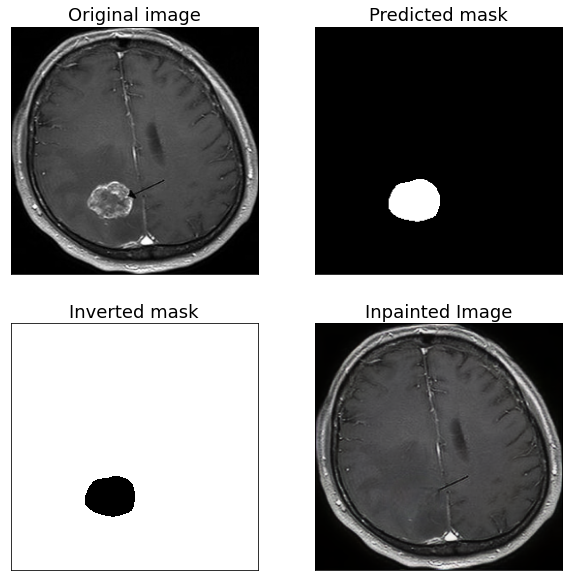

In [7]:
out=generate_inpainted_images('Y30.JPG',seg_model,inpainting_model)

## 2) Cutoff Augmentation

1/1 [==============================] - 1s 894ms/step


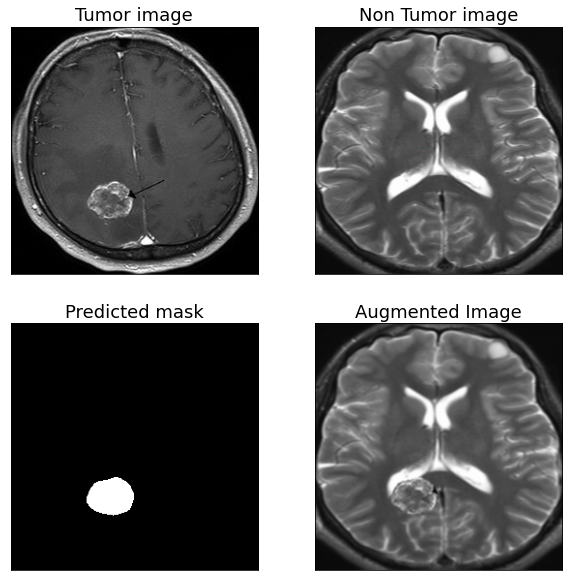

In [8]:
out=generate_cutoff_images('Y30.JPG','No17.JPG',seg_model)

## 3) RegionMix Augmentation

1/1 [==============================] - 1s 728ms/step
[0.82125914]
probabolity = 0.8212591374407393


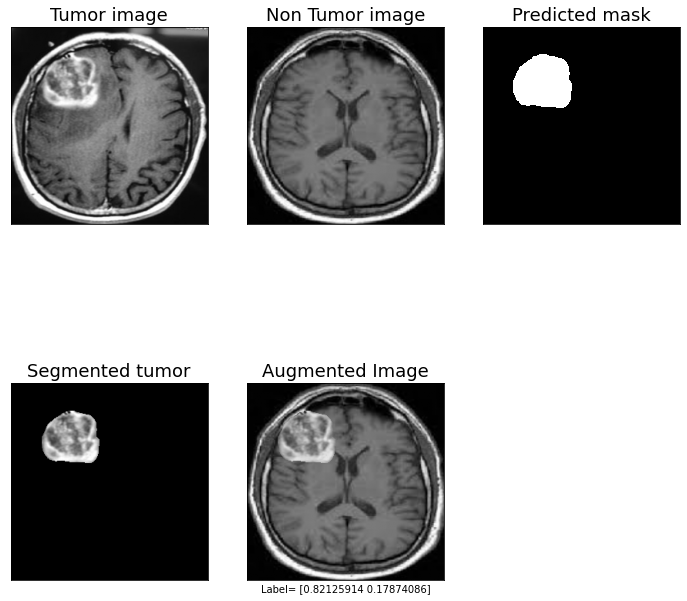

In [9]:
MixUpAugmentation("Y34.JPG","41 no.JPG",seg_model)             

## 4) Default Augmentation

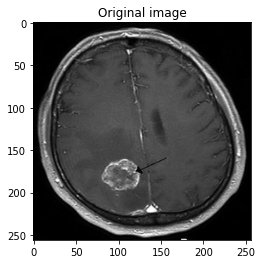

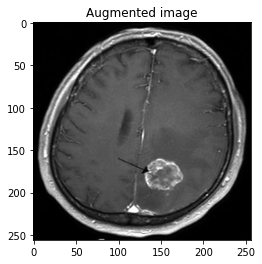

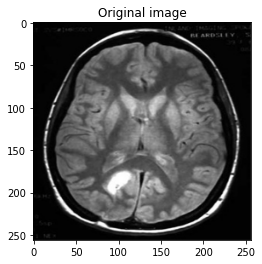

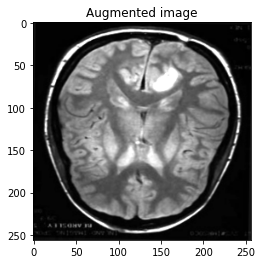

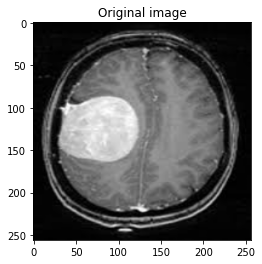

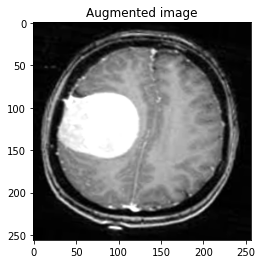

In [10]:
generate_augmented_images_through_path(r'D:\TA\Masters\brain tumor small dataset\brain_tumor_dataset\yes',2,"aa")